In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="51ffab58c8479d1e840c3e107b42e3bde7d28029e263726b133a9acdcd12c3aa8fbbd4029ccaf96fbe8e4fbbdc49e9d2f46fb939aa06e2926863584070948f61",overwrite=True)

In [3]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
# from qiskit_ibm_provider import IBMProvider
# import qiskit_ibm_provider.jupyter
# from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# # Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://docs.quantum-computing.ibm.com/run/primitives
# result = Sampler().run(circuits).result()

In [4]:
import numpy as np
import qiskit
from qiskit import *
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
# from qiskit.providers.fake_provider import *
# from qiskit_aer.pulse import *
from qiskit.providers import *

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.model_selection import train_test_split

from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate, QuantumRegister
from qiskit import schedule

# from qiskit.tools.monitor import job_monitor

# from qiskit.tools.jupyter import *
%matplotlib inline

# from qiskit import IBMQ
import qiskit_ibm_provider
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_provider.job import job_monitor
# import qiskit_ibm_provider.jupyter
# IBMProvider.save_account(token=<INSERT_IBM_QUANTUM_TOKEN>)
provider = IBMProvider()
backend_name = 'ibm_brisbane'
backend = provider.get_backend(backend_name)

backend_defaults = backend.defaults()

backend_properties = backend.properties()

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# scale data (specific to each device)
scale_factor = 1e-7

# number of shots for our experiments
NUM_SHOTS = 1024


In [10]:
from datetime import datetime

t = datetime(day=1, month=6, year=2024, hour=10)
properties = backend.properties(datetime=t)
properties.to_dict()

{'backend_name': 'ibm_brisbane',
 'backend_version': '1.1.27',
 'last_update_date': datetime.datetime(2024, 6, 1, 9, 38, 26, tzinfo=tzlocal()),
 'qubits': [[{'date': datetime.datetime(2024, 6, 1, 2, 27, 34, tzinfo=tzlocal()),
    'name': 'T1',
    'unit': 'us',
    'value': 259.07210336322055},
   {'date': datetime.datetime(2024, 6, 1, 2, 42, 8, tzinfo=tzlocal()),
    'name': 'T2',
    'unit': 'us',
    'value': 78.63434767310423},
   {'date': datetime.datetime(2024, 6, 1, 9, 38, 26, tzinfo=tzlocal()),
    'name': 'frequency',
    'unit': 'GHz',
    'value': 4.721908102810238},
   {'date': datetime.datetime(2024, 6, 1, 9, 38, 26, tzinfo=tzlocal()),
    'name': 'anharmonicity',
    'unit': 'GHz',
    'value': -0.31197865973435573},
   {'date': datetime.datetime(2024, 6, 1, 2, 1, 53, tzinfo=tzlocal()),
    'name': 'readout_error',
    'unit': '',
    'value': 0.022599999999999953},
   {'date': datetime.datetime(2024, 6, 1, 2, 1, 53, tzinfo=tzlocal()),
    'name': 'prob_meas0_prep1',
    

In [14]:
def n_hop_neighbors (victim, n_hop):
    backend = provider.get_backend(backend_name)
    coupling_map = backend.configuration().coupling_map
    qubits_at_distance_n = []

    for qubit_pair in coupling_map:
        for qubit in qubit_pair:
            if backend.coupling_map.distance(qubit,victim) == n_hop:
                qubits_at_distance_n.append(qubit)

    qubits_at_distance_n = list(set(qubits_at_distance_n))
    return qubits_at_distance_n

In [15]:
victim = 0
attacker = n_hop_neighbors(victim, 0)
n_att = np.size(attacker)
n_hop_neighbors(victim, 0)

[0]

In [45]:
v = 0
att = []
for i in range(127):
    if i>1:
        att.append(i)
n_att1 = np.size(att)
n_att1

125

In [92]:
v = 0
att = []
for i in range(127):
    if i>70:
        att.append(i)
n_att1 = np.size(att)
n_att1

56

In [16]:
default_qubit_freq = backend_defaults.qubit_freq_est[victim] # Default qubit frequency in Hz. 
print(f"Victim has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

Victim has an estimated frequency of 4.721903319753299 GHz.


In [17]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout = 200) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(np.real(job_results.get_memory(i)[0] * scale_factor))
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, 0] * scale_factor)
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [18]:
duration = 550
sigma = 40

In [ ]:
Parameter('freq')

In [105]:
# frequency sweep

num_freqs = 75
drive_power = 0.15
sweep_freqs = np.linspace(-30*MHz, 30*MHz, num_freqs)


freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as freq_sweep_sched:
    drive_chan = pulse.drive_channel(victim)
    with pulse.frequency_offset(freq, drive_chan):
        pulse.play(pulse.Gaussian(duration=duration,
                                  amp=drive_power,
                                  sigma=sigma,
                                  name='x_pulse'), drive_chan)

spect_gate = Gate("spect", 1, [freq])

qc_spect = QuantumCircuit(127, 1)

qc_spect.append(spect_gate, [victim])
qc_spect.measure(victim, 0)
qc_spect.add_calibration(spect_gate, (victim,), freq_sweep_sched, [freq])
    
exp_spect_circs = [qc_spect.assign_parameters({freq: f}) for f in sweep_freqs]

freq_sweep_job = backend.run(exp_spect_circs, 
                                     meas_level=1, 
                                     meas_return='avg', 
                                     shots=NUM_SHOTS)

job_monitor(freq_sweep_job)


# no default, [-30, 30]
### victim = 0
# job_id = "csr3tfh0c2pg008cwdh0"
# freq_sweep_job = service.job(job_id)

# ### victim = 64
# job_id = "csr5san0c2pg008cwv4g"
# freq_sweep_job = service.job(job_id)

# ### victim = 8
# job_id = "csr7r2gvnxy0008e902g"
# freq_sweep_job = service.job(job_id)

# ### victim = 13
# job_id = "csr7spyvnxy0008e90hg"
# freq_sweep_job = service.job(job_id)

# ### victim = 56
# job_id = "csr7sexea560008gb440"
# freq_sweep_job = service.job(job_id)

# ### victim = 70
# job_id = "csr9v9nvwqp0008bynyg"
# freq_sweep_job = service.job(job_id)

# ### victim = 113
# job_id = "csr9vqep1vzg008b7kxg"
# freq_sweep_job = service.job(job_id)

# ### victim = 118
# job_id = "csr9w0gea560008gbkpg"
# freq_sweep_job = service.job(job_id)




Job Status: job has successfully run                           


In [106]:

num_freqs = 75
drive_power = 0.15
sweep_freqs = np.linspace(-30*MHz, 30*MHz, num_freqs)
sweep_freqs

array([-30000000.        , -29189189.18918919, -28378378.37837838,
       -27567567.56756757, -26756756.75675676, -25945945.94594594,
       -25135135.13513514, -24324324.32432432, -23513513.51351351,
       -22702702.7027027 , -21891891.89189189, -21081081.08108108,
       -20270270.27027027, -19459459.45945946, -18648648.64864865,
       -17837837.83783784, -17027027.02702703, -16216216.21621622,
       -15405405.40540541, -14594594.5945946 , -13783783.78378378,
       -12972972.97297297, -12162162.16216216, -11351351.35135135,
       -10540540.54054054,  -9729729.72972973,  -8918918.91891892,
        -8108108.10810811,  -7297297.2972973 ,  -6486486.48648649,
        -5675675.67567568,  -4864864.86486487,  -4054054.05405406,
        -3243243.24324324,  -2432432.43243244,  -1621621.62162162,
         -810810.81081081,         0.        ,    810810.81081081,
         1621621.62162162,   2432432.43243243,   3243243.24324324,
         4054054.05405405,   4864864.86486486,   5675675.67567

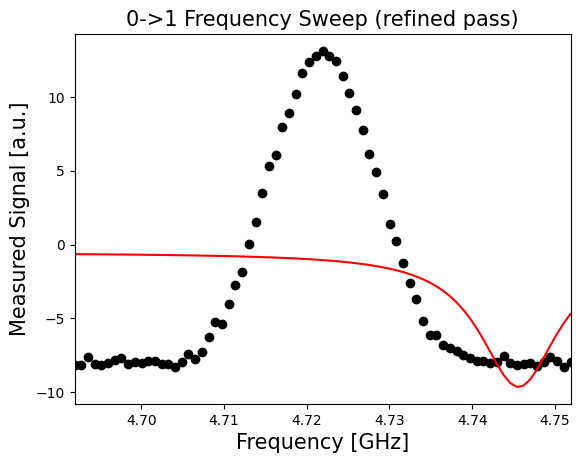

Our updated estimate for the 0->1 transition frequency is 4.7456202 GHz.


In [107]:
### victim = 0

job_id = "ctszjd166x8g008pz350"
freq_sweep_job = service.job(job_id)

# Get the refined data (average)
# plot and fit the refined signal, using the standard Lorentzian curve.
freq_sweep_data = get_job_data(freq_sweep_job, average=True)
sweep_freqs = default_qubit_freq + np.linspace(-30*MHz, 30*MHz, num_freqs)

def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit.""" 
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev = 50000)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

# # do fit in Hz
(sweep_fit_params, 
 sweep_y_fit) = fit_function(sweep_freqs,
                                     freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-20, 4.908*GHz, 0.06*GHz, 3*GHz] # initial parameters for curve_fit based on the estimated frequency
                                     )


# Note: we are only plotting the real part of the signal
plt.scatter(sweep_freqs/GHz, freq_sweep_data, color='black')
plt.plot(sweep_freqs/GHz, sweep_y_fit, color='red')
plt.xlim([min(sweep_freqs/GHz), max(sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("0->1 Frequency Sweep (refined pass)", fontsize=15)
plt.show()
# plt.savefig('DATA frequency sweep.pdf')

_, qubit_freq, _, _ = sweep_fit_params
print(f"Our updated estimate for the 0->1 transition frequency is "
      f"{round(qubit_freq/GHz, 7)} GHz.")

In [21]:
# qubit_freq = default_qubit_freq

In [108]:
# Rabi Experiment

# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

amp = Parameter('amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Amp sweep') as rabi_sched:
    drive_chan = pulse.drive_channel(victim)
    pulse.set_frequency(qubit_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=duration,
                              amp=amp,
                              sigma=sigma,
                              name='x_pulse'), drive_chan)
    
rabi_gate = Gate("rabi", 1, [amp])

qc_rabi = QuantumCircuit(127, 1)

qc_rabi.append(rabi_gate, [victim])
qc_rabi.measure(victim, 0)
qc_rabi.add_calibration(rabi_gate, (victim,), rabi_sched, [amp])
    
exp_rabi_circs = [qc_rabi.assign_parameters({amp: a}) for a in drive_amps]

rabi_job = backend.run(exp_rabi_circs, 
                          meas_level=1, 
                          meas_return='avg', 
                          shots=NUM_SHOTS)

job_monitor(rabi_job)

Job Status: job has successfully run                             


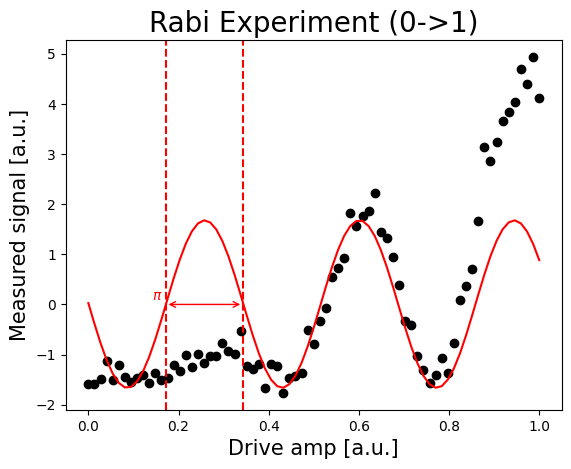

Our updated estimate for the 0->1 transition frequency is 4.7456202 GHz.
Pi Amplitude (0->1) = 0.1715937439168631


In [109]:
## Get the job data (average)
# ### victim = 0
# job_id = "csr4n8dvnxy0008e897g"
# rabi_job = service.job(job_id)

# ### victim = 64
# job_id = "csr5w8sea560008garmg"
# rabi_job = service.job(job_id)

# ### victim = 8
# job_id = "csr9ms31k2e0008q1z7g"
# rabi_job = service.job(job_id)

# ### victim = 13
# job_id = "csr9ngeea560008gbjf0"
# rabi_job = service.job(job_id)

# ### victim = 56
# job_id = "csr9pptea560008gbjm0"
# rabi_job = service.job(job_id)

# ### victim = 70
# job_id = ""
# freq_sweep_job = service.job(job_id)

# ### victim = 113
# job_id = "csrdjzbea560008gcdz0"
# freq_sweep_job = service.job(job_id)

# ### victim = 118
# job_id = "csrdke51k2e0008q2s00"
# freq_sweep_job = service.job(job_id)

### victim = 0
job_id = "ctt22f1seb10008wxqd0"
freq_sweep_job = service.job(job_id)


rabi_data = get_job_data(rabi_job, average=True)

def baseline_remove(values):
    """Center data around 0."""
    return np.array(values) - np.mean(values)

# Note: Only real part of data is plotted
rabi_data = np.real(baseline_remove(rabi_data))
(rabi_fit_params, 
 rabi_y_fit) = fit_function(drive_amps,
                               rabi_data, 
                               lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                               [0.2, 0, 0.3, 0])

plt.scatter(drive_amps, rabi_data, color='black')
plt.plot(drive_amps, rabi_y_fit, color='red')

drive_period = rabi_fit_params[2] 

pi_amp = drive_period/2

plt.axvline(pi_amp, color='red', linestyle='--')
plt.axvline(pi_amp+drive_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp+drive_period/2, 0), xytext=(pi_amp,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (0->1)', fontsize=20)
plt.show()

print(f"Our updated estimate for the 0->1 transition frequency is "
      f"{round(qubit_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (0->1) = {pi_amp}")

In [110]:
rabi_fit_params

array([ 1.66999355,  0.00737162,  0.34318749, -1.55862434])

In [111]:
qubit_freq

4745620222.056917

In [112]:
with pulse.build(backend=backend, default_alignment='sequential', name='schedule') as sched:
    drive_chan = pulse.drive_channel(1)
    pulse.set_frequency(qubit_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration,
                              pi_amp,
                              sigma,
                              name='pulse'), drive_chan)
    
custom_gate = Gate("pulse", 1, [])

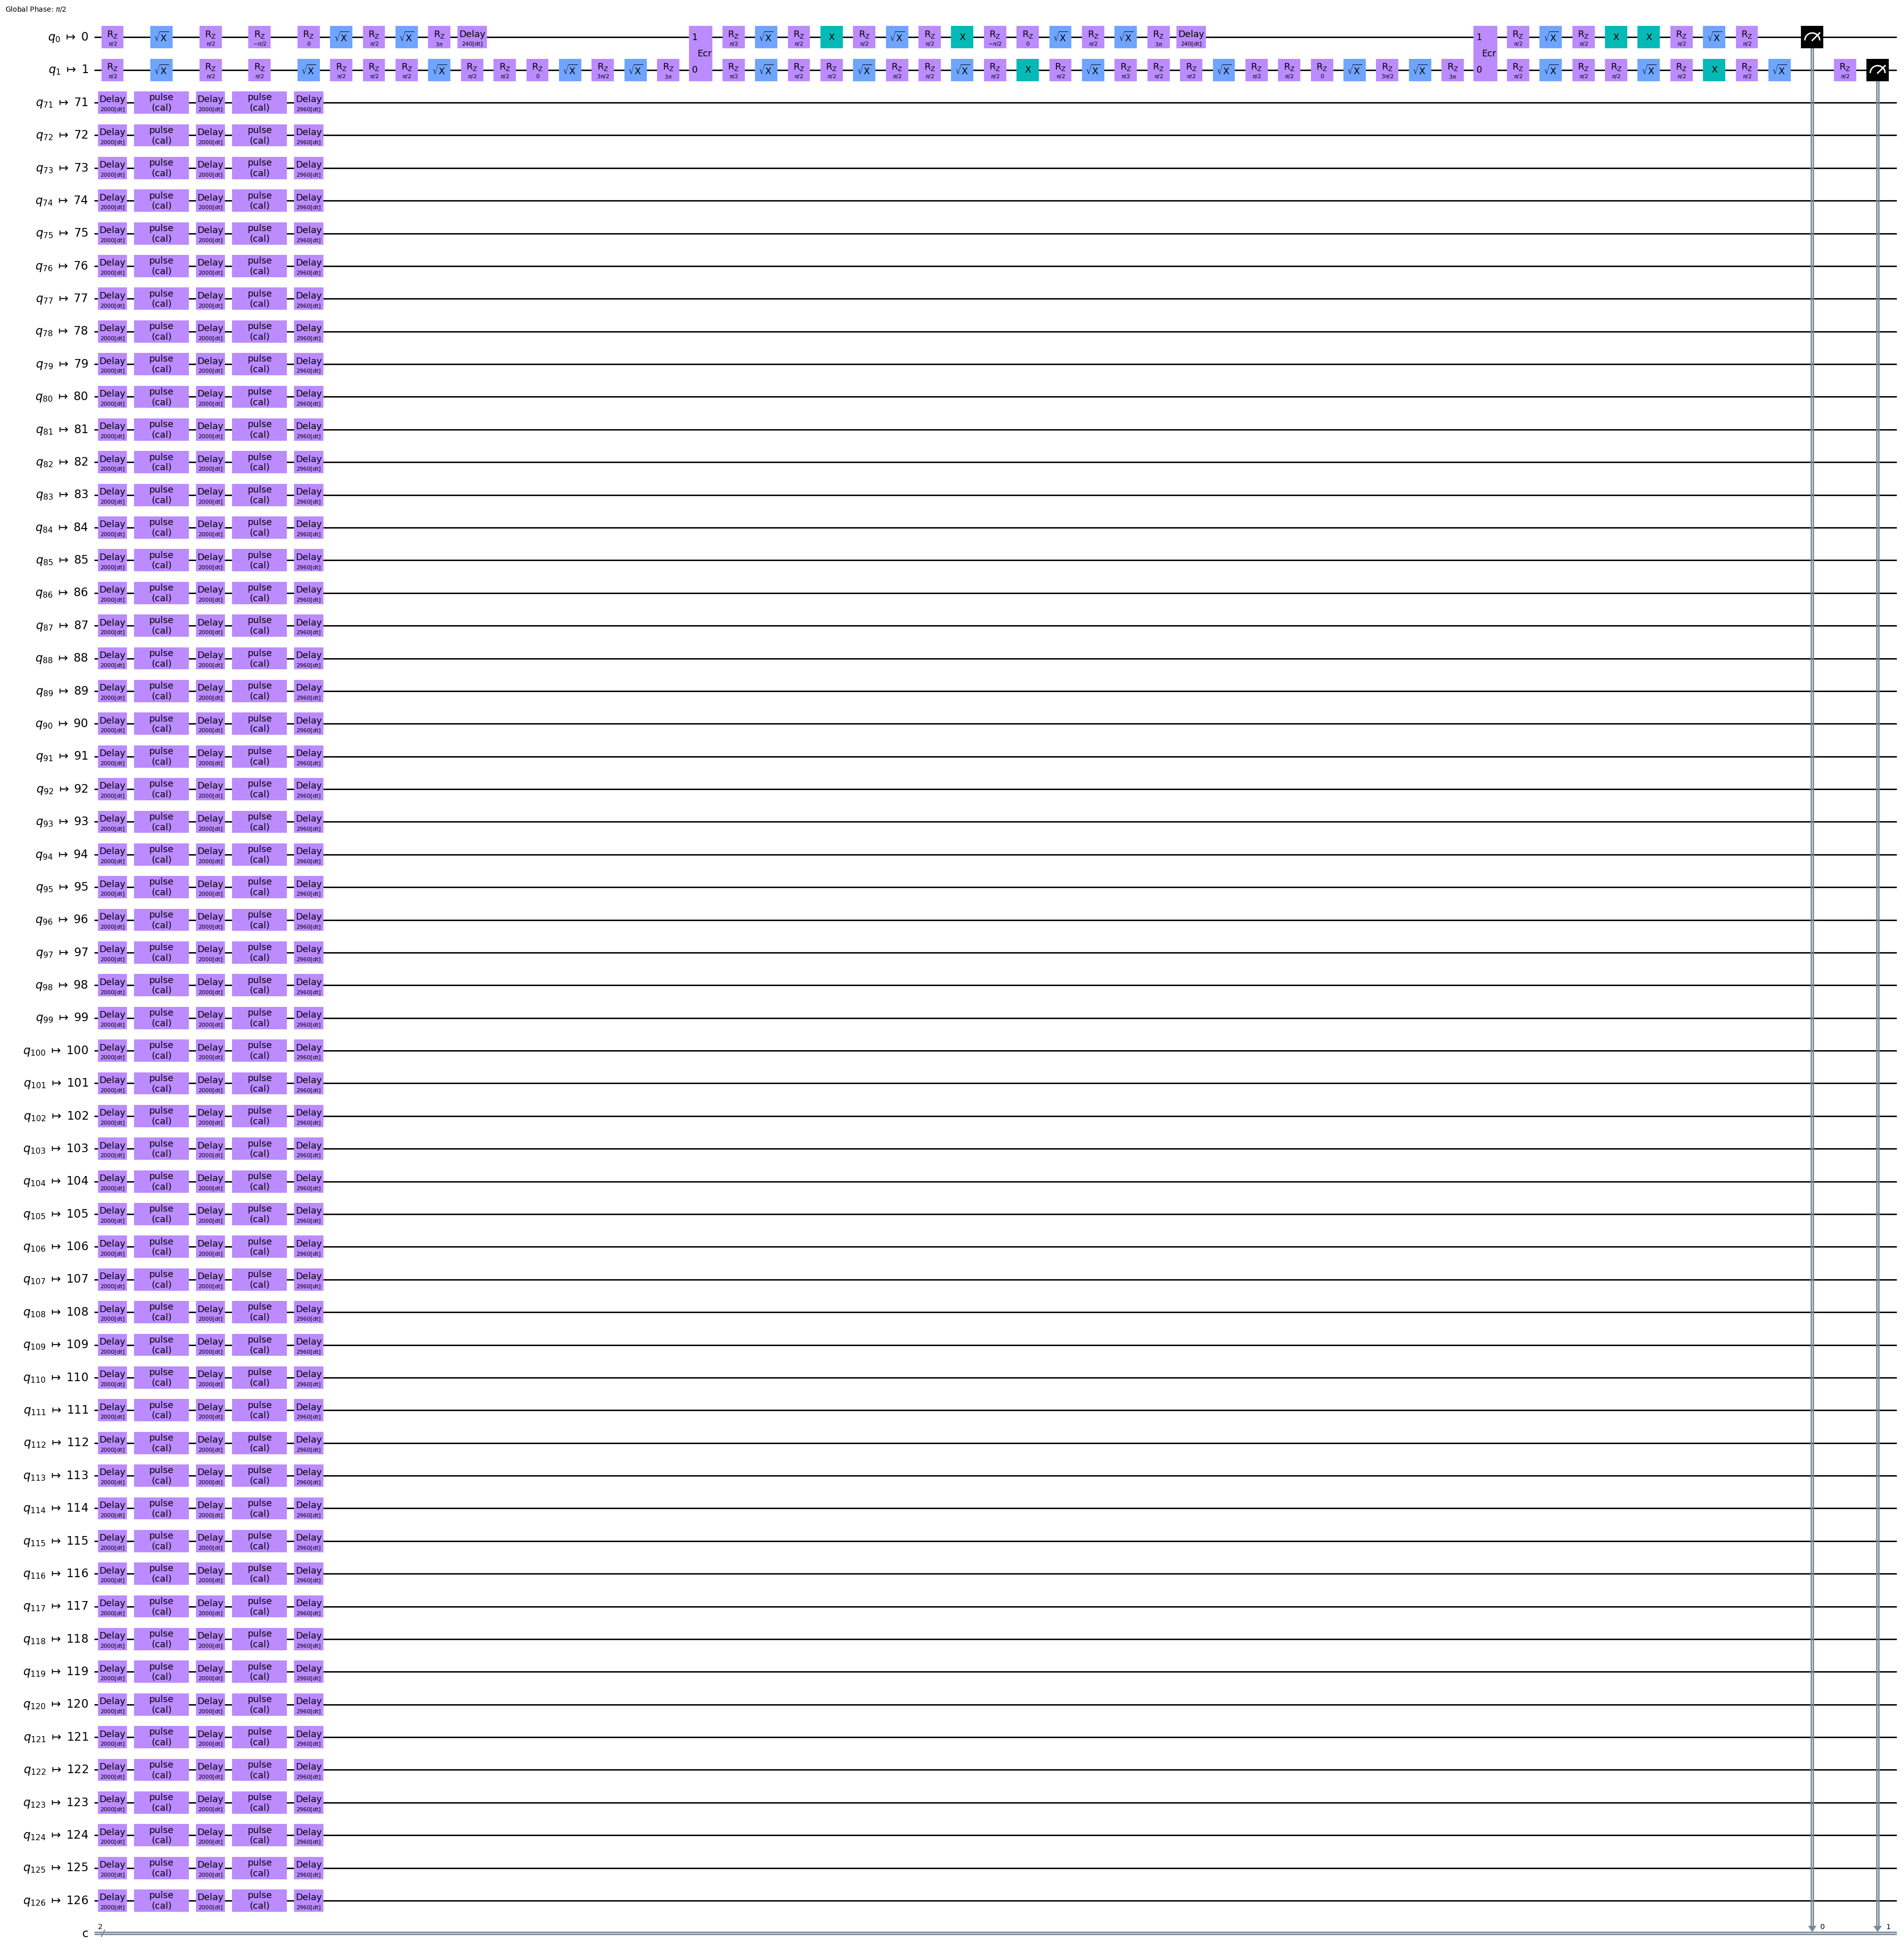

In [113]:
# Grover

# qc = QuantumCircuit(127, 1)

qreg_q = QuantumRegister(127, 'q')
creg_c = ClassicalRegister(2, 'c')
qc = QuantumCircuit(qreg_q, creg_c)

qc.h(qreg_q[0])
qc.h(qreg_q[1])
qc.h(qreg_q[1])
qc.cx(qreg_q[0], qreg_q[1])
qc.h(qreg_q[1])
qc.h(qreg_q[0])
qc.h(qreg_q[1])
qc.x(qreg_q[0])
qc.x(qreg_q[1])
qc.h(qreg_q[1])
qc.cx(qreg_q[0], qreg_q[1])
qc.h(qreg_q[1])
qc.x(qreg_q[0])
qc.x(qreg_q[1])
qc.h(qreg_q[0])
qc.h(qreg_q[1])

add_delay = 0

for i in range(n_att1):
    # qc.append(custom_gate, [att[i]])
    qc.delay(2000, att[i])
    qc.append(custom_gate, [att[i]])
    qc.delay(2000, att[i])
    qc.append(custom_gate, [att[i]])
    # qc.delay(2000, att[i])
    # qc.append(custom_gate, [att[i]])
    qc.add_calibration(custom_gate, (att[i],), sched, [])
    # add_delay += 50


qc.measure(qreg_q[0], creg_c[0])
qc.measure(qreg_q[1], creg_c[1])

# target_state = qi.Statevector.from_instruction(qc)

qc_tr = transpile(qc, backend, scheduling_method = "asap", layout_method='trivial', optimization_level=0)
qc_tr.draw(output='mpl', idle_wires=False, fold=1)

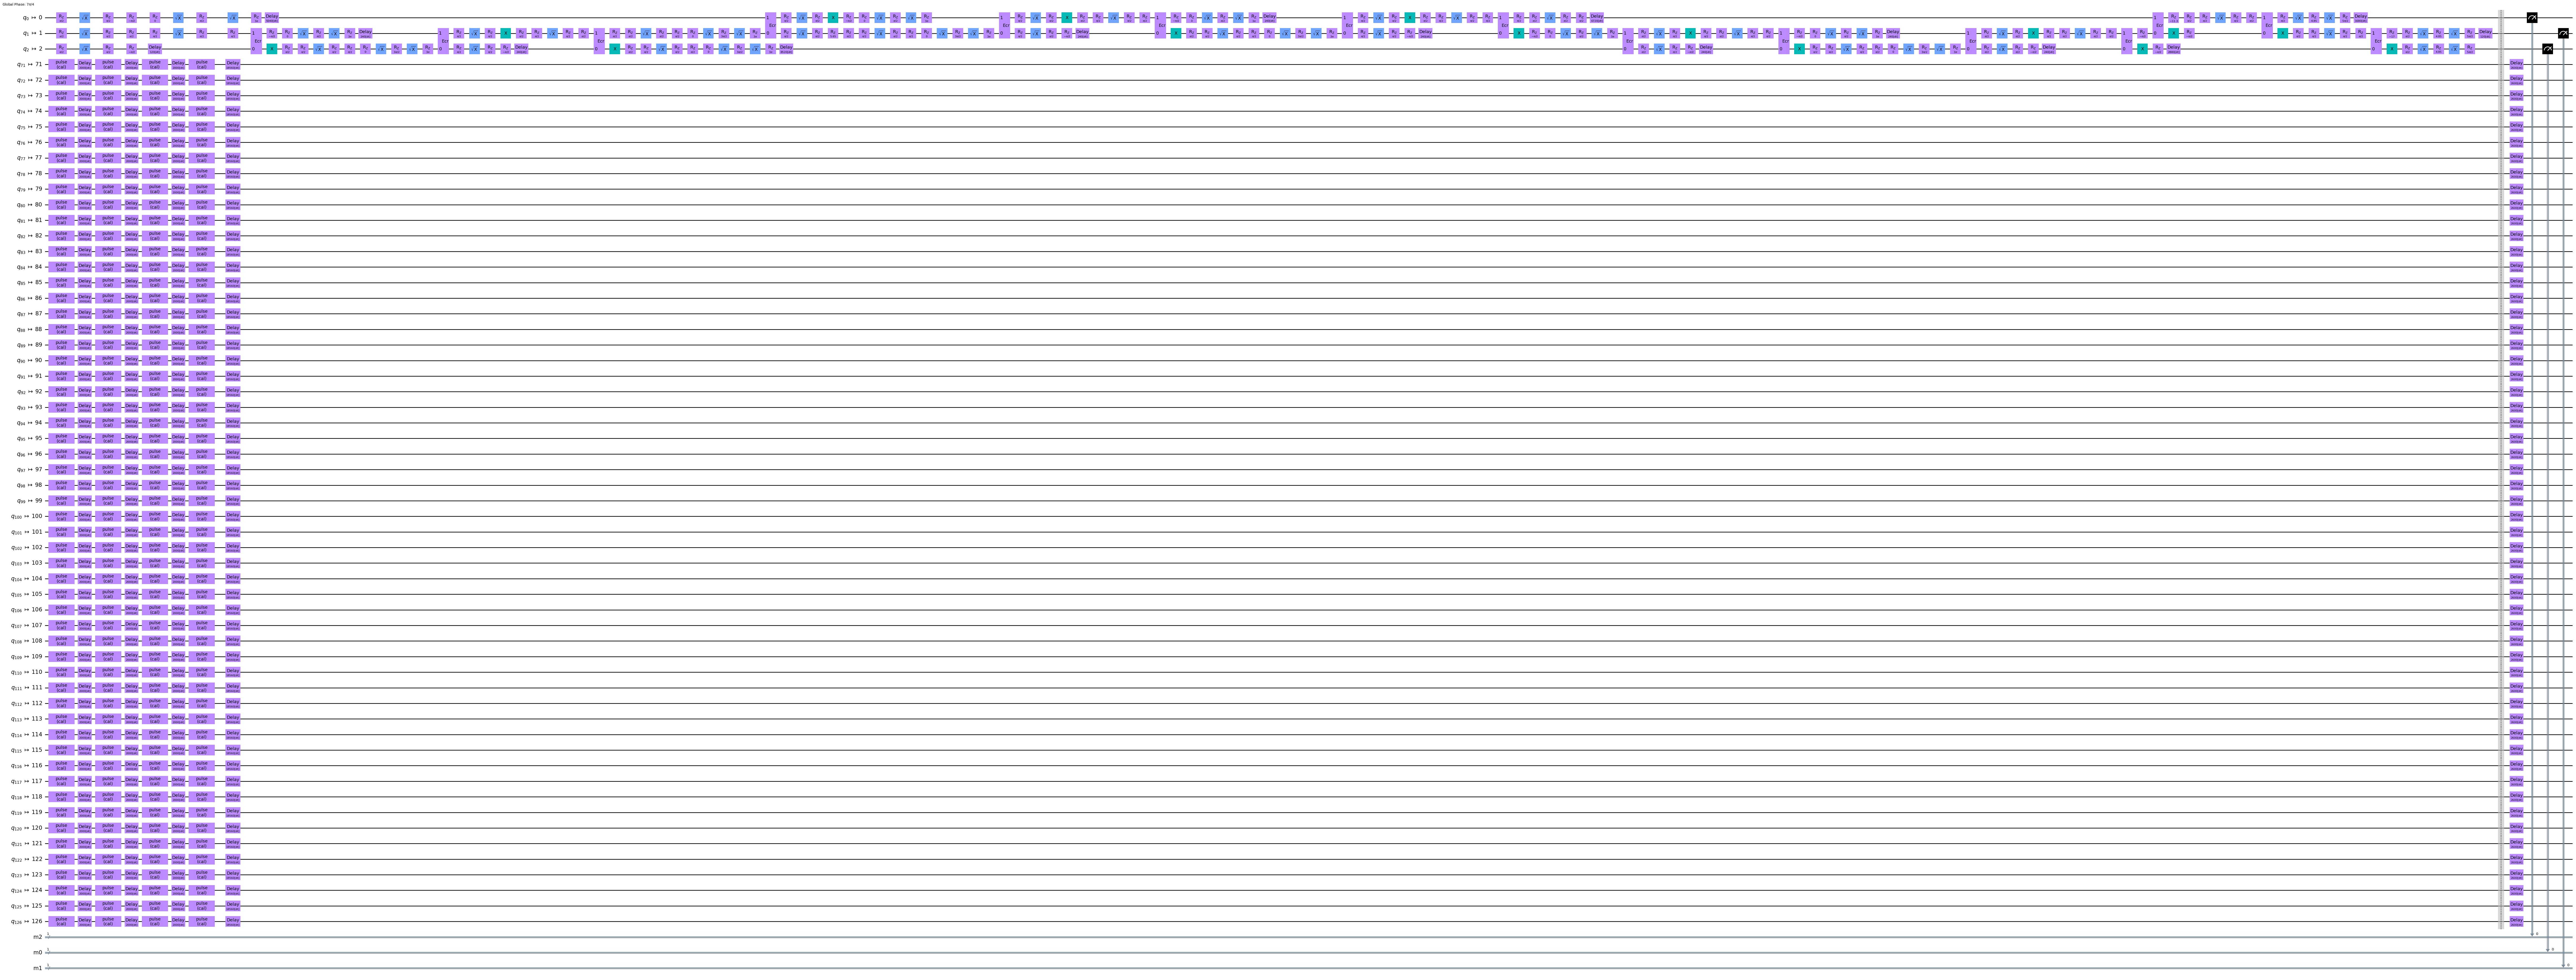

In [133]:
pi = 3.14

qreg_q = QuantumRegister(127, 'q')
creg_m2 = ClassicalRegister(1, 'm2')
creg_m0 = ClassicalRegister(1, 'm0')
creg_m1 = ClassicalRegister(1, 'm1')
qc = QuantumCircuit(qreg_q, creg_m2, creg_m0, creg_m1)

# Finding the max of the cost function: C = -1 + z(0)z(2) - 2 z(0)z(1)z(2) - 3 z(1) 
# Starting with p = 1
# Generated from Cirq v0.8.0
# Qubits: [(0, 0), (1, 0), (2, 0)]
qc.h(qreg_q[0])
qc.h(qreg_q[1])
qc.h(qreg_q[2])
qc.cx(qreg_q[0], qreg_q[2])
qc.rz(pi * 1.79986, qreg_q[2])
qc.cx(qreg_q[0], qreg_q[2])
qc.cx(qreg_q[0], qreg_q[1])
qc.cx(qreg_q[1], qreg_q[2])
qc.rz(pi * -3.59973, qreg_q[2])
qc.cx(qreg_q[1], qreg_q[2])
qc.cx(qreg_q[0], qreg_q[1])
qc.rx(pi * 0.545344, qreg_q[2])
qc.rz(pi * -5.39959, qreg_q[1])
qc.rx(pi * 0.545344, qreg_q[0])
# qc.measure(qreg_q[2], creg_m2[0])
qc.rx(pi * 0.545344, qreg_q[1])
# qc.measure(qreg_q[0], creg_m0[0])
# qc.measure(qreg_q[1], creg_m1[0])

add_delay = 0

for i in range(n_att1):
    qc.append(custom_gate, [att[i]])
    qc.delay(2000, att[i])
    qc.append(custom_gate, [att[i]])
    qc.delay(2000, att[i])
    qc.append(custom_gate, [att[i]])
    qc.delay(2000, att[i])
    qc.append(custom_gate, [att[i]])
    qc.add_calibration(custom_gate, (att[i],), sched, [])
#     # add_delay += 50


qc.measure(qreg_q[2], creg_m2[0])
qc.measure(qreg_q[0], creg_m0[0])
qc.measure(qreg_q[1], creg_m1[0])

# target_state = qi.Statevector.from_instruction(qc)

qc_tr = transpile(qc, backend, scheduling_method = "asap", layout_method='trivial', optimization_level=0)
qc_tr.draw(output='mpl', idle_wires=False, fold =1)


In [43]:
# qc = QuantumCircuit(127, 1)

qreg_q = QuantumRegister(127, 'q')
creg_c = ClassicalRegister(2, 'c')
qc = QuantumCircuit(qreg_q, creg_c)

# qc.h(qreg_q[0])
# qc.h(qreg_q[1])
# qc.h(qreg_q[1])
# qc.cx(qreg_q[0], qreg_q[1])
# qc.h(qreg_q[1])
# qc.h(qreg_q[0])
# qc.h(qreg_q[1])
# qc.x(qreg_q[0])
# qc.x(qreg_q[1])
# qc.h(qreg_q[1])
# qc.cx(qreg_q[0], qreg_q[1])
# qc.h(qreg_q[1])
# qc.x(qreg_q[0])
# qc.x(qreg_q[1])
# qc.h(qreg_q[0])
# qc.h(qreg_q[1])

# for i in range(127):/
# for i in range(n_att):
#     qc.append(custom_gate, [attacker[i]])
#     qc.add_calibration(custom_gate, (attacker[i],), sched, [])
for i in range(n_att):
    qc.append(custom_gate, [attacker[i]])
    qc.add_calibration(custom_gate, (attacker[i],), sched, [])

qc.measure(qreg_q[0], creg_c[0])
qc.measure(qreg_q[1], creg_c[1])

# target_state = qi.Statevector.from_instruction(qc)

qc_tr = transpile(qc, backend, scheduling_method = "asap", layout_method='trivial', optimization_level=0)
qc_tr.draw(idle_wires=False)

┌───────┐   ┌─┐                  
q_0 -> 0 ┤ pulse ├───┤M├──────────────────
         └───────┘┌─┐└╥┘┌────────────────┐
q_1 -> 1 ─────────┤M├─╫─┤ Delay(160[dt]) ├
                  └╥┘ ║ └────────────────┘
    c: 2/══════════╩══╩═══════════════════
                   1  0

In [129]:
job = backend.run([qc_tr], 
                  meas_level=2, 
                  meas_return='single', 
                  shots=NUM_SHOTS)
job_monitor(job)

Job Status: job has successfully run                            


In [130]:
job_id_0 = "cttk6k23zkm0008sdgpg"
job = service.job(job_id_0)
result = job.result()
counts_0 = result.get_counts()

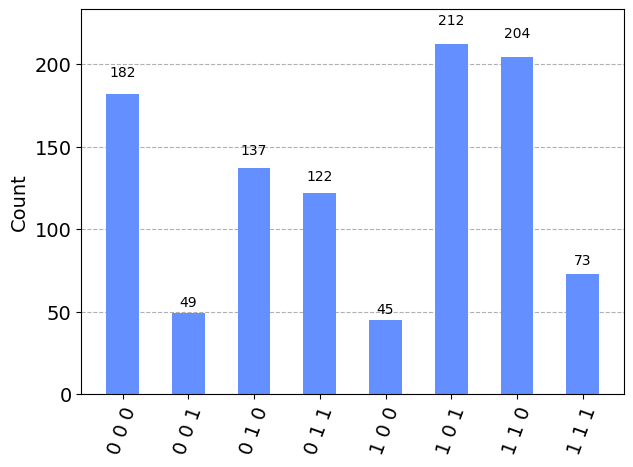

In [131]:
plot_histogram(counts_0)

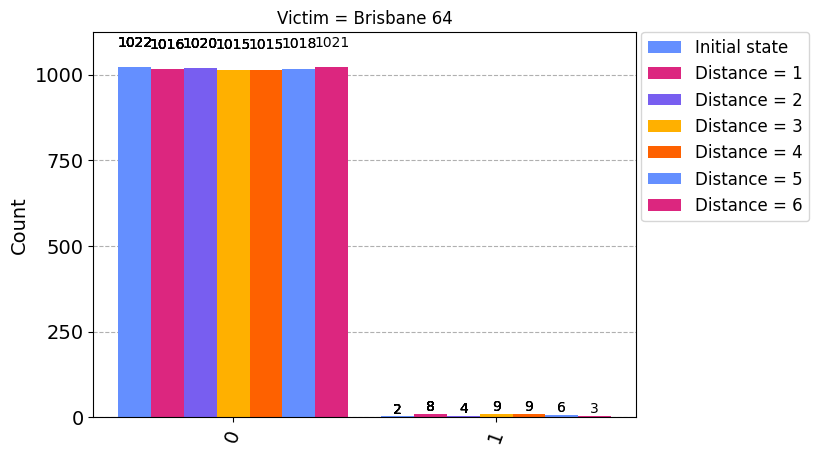

In [ ]:
### victim = 64
job_id_0 = "csr5x9nvwqp0008bxr60"
job = service.job(job_id_0)
result = job.result()
counts_0 = result.get_counts()

job_id_1 = "csr5wt3vnxy0008e8jc0"
job = service.job(job_id_1)
result = job.result()
counts_1 = result.get_counts()

job_id_2 = "csr5xszvnxy0008e8jn0"
job = service.job(job_id_2)
result = job.result()
counts_2 = result.get_counts()

job_id_3 = "csr5y7gvnxy0008e8jq0"
job = service.job(job_id_3)
result = job.result()
counts_3 = result.get_counts()

job_id_4 = "csr5ygjvnxy0008e8jv0"
job = service.job(job_id_4)
result = job.result()
counts_4 = result.get_counts()

job_id_5 = "csr5yt30c2pg008cww7g"
job = service.job(job_id_5)
result = job.result()
counts_5 = result.get_counts()

job_id_6 = "csr5z3wvwqp0008bxrhg"
job = service.job(job_id_6)
result = job.result()
counts_6 = result.get_counts()

plot_histogram([counts_0, counts_1, counts_2, counts_3, counts_4, counts_5, counts_6],
               legend = ['Initial state', 'Distance = 1', 'Distance = 2', 'Distance = 3', 'Distance = 4', 'Distance = 5', 'Distance = 6'],
               title = "Victim = Brisbane 64")


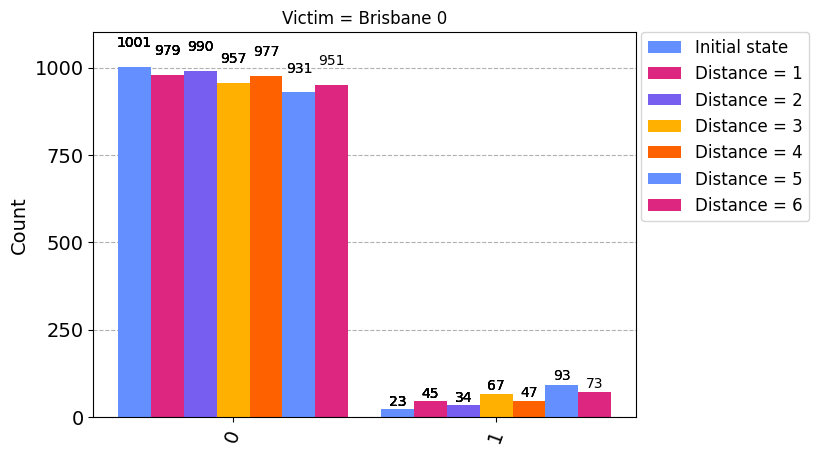

In [69]:
### victim = 0
job_id_0 = "csr4qqep1vzg008b6p50"
job = service.job(job_id_0)
result = job.result()
counts_0 = result.get_counts()

job_id_1 = "csr4qanvwqp0008bxjkg"
job = service.job(job_id_1)
result = job.result()
counts_1 = result.get_counts()

job_id_2 = "csr5g30p1vzg008b6svg"
job = service.job(job_id_2)
result = job.result()
counts_2 = result.get_counts()

job_id_3 = "csr5hgevnxy0008e8fpg"
job = service.job(job_id_3)
result = job.result()
counts_3 = result.get_counts()

job_id_4 = "csr5hs7vnxy0008e8fqg"
job = service.job(job_id_4)
result = job.result()
counts_4 = result.get_counts()

job_id_5 = "csr5jw31k2e0008q10y0"
job = service.job(job_id_5)
result = job.result()
counts_5 = result.get_counts()

job_id_6 = "csr5kbdvnxy0008e8g20"
job = service.job(job_id_6)
result = job.result()
counts_6 = result.get_counts()

plot_histogram([counts_0, counts_1, counts_2, counts_3, counts_4, counts_5, counts_6],
               legend = ['Initial state', 'Distance = 1', 'Distance = 2', 'Distance = 3', 'Distance = 4', 'Distance = 5', 'Distance = 6'],
               title = "Victim = Brisbane 0")


In [7]:
### victim = 0
job_id_0 = "csr4qqep1vzg008b6p50"
job = service.job(job_id_0)
result = job.result()
counts_0 = result.get_counts()

job_id_1 = "csr4qanvwqp0008bxjkg"
job = service.job(job_id_1)
result = job.result()
counts_1 = result.get_counts()

job_id_2 = "csr5g30p1vzg008b6svg"
job = service.job(job_id_2)
result = job.result()
counts_2 = result.get_counts()

job_id_3 = "csr5hgevnxy0008e8fpg"
job = service.job(job_id_3)
result = job.result()
counts_3 = result.get_counts()

job_id_4 = "csr5hs7vnxy0008e8fqg"
job = service.job(job_id_4)
result = job.result()
counts_4 = result.get_counts()

job_id_5 = "csr5jw31k2e0008q10y0"
job = service.job(job_id_5)
result = job.result()
counts_5 = result.get_counts()

job_id_6 = "csr5kbdvnxy0008e8g20"
job = service.job(job_id_6)
result = job.result()
counts_6 = result.get_counts()

plot_histogram([counts_0, counts_1, counts_2, counts_3, counts_4, counts_5, counts_6],
               legend = ['Initial state', 'Distance = 1', 'Distance = 2', 'Distance = 3', 'Distance = 4', 'Distance = 5', 'Distance = 6'],
               title = "Victim = Brisbane 0")


RuntimeJobNotFound: 'Job not found: 404 Client Error: Not Found for url: https://api.quantum.ibm.com/runtime/jobs/csr4qqep1vzg008b6p50?exclude_params=true. {"errors":[{"code":1291,"message":"Job not found. Job ID: csr4qqep1vzg008b6p50","solution":"Verify the job ID is correct, and that you have the correct access permissions.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}'

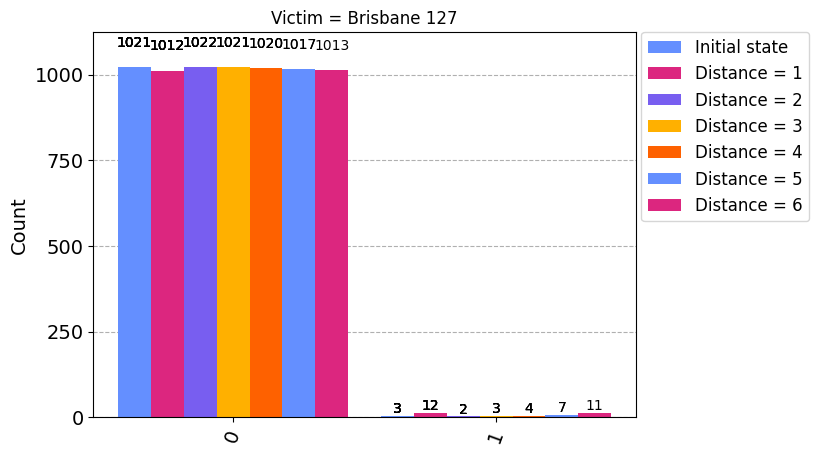

In [8]:
### victim = 127


job_id_1 = "cst9pfh7ynng008yhv3g"
job = service.job(job_id_1)
result = job.result()
counts_1 = result.get_counts()

job_id_2 = "csttbjesgar0008bz8f0"
job = service.job(job_id_2)
result = job.result()
counts_2 = result.get_counts()

job_id_3 = "cswtt2gzsqjg008tshc0"
job = service.job(job_id_3)
result = job.result()
counts_3 = result.get_counts()

job_id_4 = "cswvnmpvkv50008gzz0g"
job = service.job(job_id_4)
result = job.result()
counts_4 = result.get_counts()

job_id_5 = "csxegvkjkdzg0089g3sg"
job = service.job(job_id_5)
result = job.result()
counts_5 = result.get_counts()

job_id_6 = "csxrkan8cwag008wp510"
job = service.job(job_id_6)
result = job.result()
counts_6 = result.get_counts()

job_id_0 = "csy6snyyn5c0008bxph0"
job = service.job(job_id_0)
result = job.result()
counts_0 = result.get_counts()

plot_histogram([counts_0, counts_1, counts_2, counts_3, counts_4, counts_5, counts_6],
               legend = ['Initial state', 'Distance = 1', 'Distance = 2', 'Distance = 3', 'Distance = 4', 'Distance = 5', 'Distance = 6'],
               title = "Victim = Brisbane 127")


In [84]:
job_id = "csy5eybagpe0008ktg00"
freq_sweep_job = service.job(job_id)


rabi_data = get_job_data(rabi_job, average=True)

rabi_data = get_job_data(job_id, average=True)
rabi_data

[-12.613862734506354,
 -12.043614817497556,
 -10.293849877810361,
 -8.308447060410558,
 -4.2216216878787876,
 -1.288018578005865,
 2.083355747214076,
 5.504390014858259,
 8.535046959824045,
 10.121662511534701,
 10.386932765298143,
 9.597111913978495,
 8.562586779765395,
 5.8764077325513195,
 2.7475453402737045,
 -1.2114039508308894,
 -4.864781380840664,
 -8.04911978465298,
 -10.86084193548387,
 -11.91212194516129,
 -12.628554135581622,
 -12.012720564516128,
 -10.726545596285435,
 -7.600485604007821,
 -5.1475085039100685,
 -1.0417085818181817,
 2.8911928747800584,
 5.702424403910068,
 8.475874872336265,
 9.691325283577712,
 10.526845051515151,
 10.096876909384164,
 8.550654467937438,
 6.605063707526882,
 2.7748320035190615,
 -0.3542262671554252,
 -3.590753305865103,
 -6.685716048484848,
 -9.529458939100683,
 -11.441952201661778,
 -12.240924000293255,
 -11.999640328739002,
 -11.694665814173998,
 -9.866564906744868,
 -6.529123839100684,
 -5.09551994916911,
 -0.6205279028347995,
 1.417552